In [1]:
import pandas as pd
import numpy as np
import time
import feather

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

### Some notes about the data 

* TAXINCL - Mortgage payment includes property taxes (0-N/A, 1-No, 2-Yes)
* INSINCL - Mortgage payment includes property insurance (0-N/A, 1-No, 2-Yes)
------------------
* HHINCOME - Total household income
* INCTOT - Total personal income; 9999999 is for N/A
* INCEARN - -$9999 is for 0 income or loss
------------------
* SERIAL is an 8-digit numeric variable which assigns a unique identification number to each household record in a given sample (See PERNUM for the analogous person record identifier). A combination of YEAR, DATANUM, and SERIAL provides a unique identifier for every household in the IPUMS; the combination of YEAR, DATANUM, SERIAL, and PERNUM uniquely identifies every person in the database. 
* DATANUM identifies the particular sample from which the case is drawn in a given year. For most censuses, the IPUMS has multiple datasets available which were constructed using different sampling techniques (i.e. size/demographic of the sample population, geographic coverage level or location, or duration of the sampling period for the ACS/PRCS samples).

In [2]:
# # reading in the full data
# start = time.time()
# df_full = feather.read_dataframe('/home/hkaren/data/census/ipums_2000-2015.feather')
# print time.time()-start
# df_full.shape
# # takes ~1100 sec

In [3]:
# # basic filtering before sampling
# df_full = df_full[df_full.YEAR > 2005]
# df_full = df_full[df_full.INCEARN > 100]

In [4]:
# # randomly sampling n rows
# start = time.time()
# df_small = df_full.sample(n = 1000000, random_state=1234)
# print time.time()-start
# df_small.shape
# del df_full
# feather.write_dataframe(df_small, '/home/hkaren/data/census/ipums_2000-2015_small.feather')

In [9]:
path = '/home/hkaren/data/census/'
df = feather.read_dataframe(path + 'ipums_2000-2015_small.feather')

In [10]:
c = df.columns.values
col_names = list(c)
print c

['RECTYPE' 'YEAR' 'DATANUM' 'SERIAL' 'NUMPREC' 'SUBSAMP' 'HHWT' 'HHTYPE'
 'REPWT' 'CLUSTER' 'ADJUST' 'CPI99' 'REGION' 'STATEICP' 'STATEFIP' 'COUNTY'
 'COUNTYFIPS' 'METRO' 'METAREA' 'METAREAD' 'MET2013' 'MET2013ERR' 'CITY'
 'CITYERR' 'CITYPOP' 'PUMA' 'PUMARES2MIG' 'STRATA' 'PUMASUPR' 'CONSPUMA'
 'CPUMA0010' 'APPAL' 'APPALD' 'HOMELAND' 'MET2003' 'CNTRY' 'GQ' 'GQTYPE'
 'GQTYPED' 'FARM' 'OWNERSHP' 'OWNERSHPD' 'MORTGAGE' 'MORTGAG2' 'COMMUSE'
 'FARMPROD' 'ACREHOUS' 'MORTAMT1' 'MORTAMT2' 'TAXINCL' 'INSINCL' 'PROPINSR'
 'PROPTX99' 'OWNCOST' 'RENT' 'RENTGRS' 'RENTMEAL' 'CONDOFEE' 'MOBLHOME'
 'MOBLHOM2' 'MOBLOAN' 'SECRES' 'SECRESMO' 'SECRESRE' 'COSTELEC' 'COSTGAS'
 'COSTWATR' 'COSTFUEL' 'HHINCOME' 'PUBHOUS' 'RENTSUB' 'HEATSUB' 'LUNCHSUB'
 'FOODSTMP' 'FDSTPAMT' 'VALUEH' 'LINGISOL' 'VACANCY' 'KITCHEN'
 'KITCHENORIG' 'FRIDGE' 'FRIDGEORIG' 'SINK' 'STOVE' 'ROOMS' 'ROOMSORIG'
 'PLUMBING' 'HOTWATER' 'SHOWER' 'TOILET' 'BUILTYR' 'BUILTYR2' 'UNITSSTR'
 'BEDROOMS' 'BEDROOMSORIG' 'PHONE' 'PHONEORIG' 'CILAPT

In [11]:
income_cols = [col for col in col_names if 'INC' in col]
# remove non income cols
income_cols.remove('TAXINCL') 
income_cols.remove('INSINCL')

In [12]:
income_cols

['HHINCOME',
 'INCTOT',
 'FTOTINC',
 'INCWAGE',
 'INCBUS00',
 'INCSS',
 'INCWELFR',
 'INCINVST',
 'INCRETIR',
 'INCSUPP',
 'INCOTHER',
 'INCEARN']

In [13]:
for cols in income_cols:
    print cols, df[cols].nunique()

HHINCOME 33945
INCTOT 16545
FTOTINC 32924
INCWAGE 1015
INCBUS00 1256
INCSS 520
INCWELFR 286
INCINVST 1032
INCRETIR 690
INCSUPP 244
INCOTHER 552
INCEARN 4411


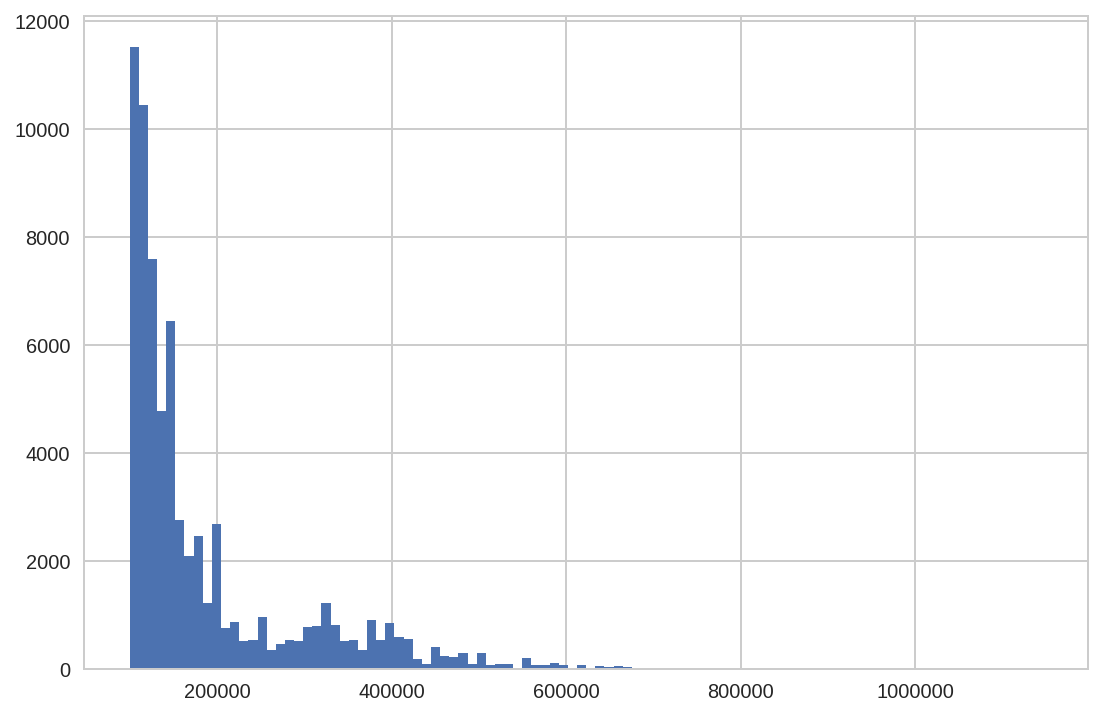

In [14]:
df[df.INCEARN > 100000].INCEARN.hist(bins=100, figsize = (9,6))

In [15]:
for col in df.select_dtypes(include=['O']).columns:
    df[col+'_le'] = LabelEncoder().fit_transform(list(df[col].values))

In [16]:
# selecting only numerical columns
init_num_cols = [e for e in df.columns if e not in df.select_dtypes(include=['O']).columns]

In [17]:
inc_corr = df[income_cols].corr()

In [18]:
cm=sns.diverging_palette(1, 130, l=60, sep = 1, as_cmap=True)
inc_corr.style.background_gradient(cmap=cm, low = 0.9, high = 0)
#ax = sns.heatmap(inc_corr, cmap=cm)

In [20]:
# Removing income columns
for col in income_cols:
    if col != "INCEARN":
        del df[col]

In [21]:
# Dropping ID columns
id_cols = ['SERIAL', 'PERNUM']
for col in id_cols:
    del df[col]

In [22]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    #corr_matrix = x
    iters = range(len(corr_matrix.columns))
    drop_cols = []
    drop_col_names = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:j+1, i:i+1]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 3))
                drop_cols.append(i)
                drop_col_names.append(col.values[0])

    # drops = sorted(set(drop_cols))[::-1]
    drops = list(set(drop_col_names))
    
    return drops

In [23]:
corr_cols = corr_df(df, 0.99)

('COUNTYFIPS', '|', 'COUNTY', '|', 1.0)
('METAREAD', '|', 'METAREA', '|', 1.0)
('PUMARES2MIG', '|', 'PUMA', '|', 0.998)
('STRATA', '|', 'PUMA', '|', 1.0)
('STRATA', '|', 'PUMARES2MIG', '|', 0.998)
('PUMASUPR', '|', 'STATEFIP', '|', 1.0)
('CPUMA0010', '|', 'STATEFIP', '|', 0.996)
('CPUMA0010', '|', 'PUMASUPR', '|', 0.996)
('APPALD', '|', 'APPAL', '|', 1.0)
('GQTYPED', '|', 'GQTYPE', '|', 1.0)
('OWNERSHPD', '|', 'OWNERSHP', '|', 0.99)
('RENTGRS', '|', 'RENT', '|', 0.99)
('VALUEH', '|', 'OWNCOST', '|', 0.999)
('KITCHENORIG', '|', 'KITCHEN', '|', 0.995)
('FRIDGEORIG', '|', 'FRIDGE', '|', 0.996)
('SINK', '|', 'FRIDGE', '|', 0.992)
('SINK', '|', 'FRIDGEORIG', '|', 0.992)
('ROOMSORIG', '|', 'ROOMS', '|', 0.995)
('PLUMBING', '|', 'SINK', '|', 0.991)
('HOTWATER', '|', 'FRIDGE', '|', 0.992)
('HOTWATER', '|', 'FRIDGEORIG', '|', 0.991)
('HOTWATER', '|', 'SINK', '|', 0.995)
('HOTWATER', '|', 'PLUMBING', '|', 0.994)
('SHOWER', '|', 'SINK', '|', 0.991)
('SHOWER', '|', 'PLUMBING', '|', 0.993)
('TOILET

In [24]:
# what datatypes are in the data
dt = df.dtypes
dt.unique()

array([dtype('O'), dtype('int32'), dtype('float64'), dtype('int64')], dtype=object)

In [25]:
df.get_dtype_counts()

float64    273
int32      170
int64        3
object       3
dtype: int64

In [26]:
df.select_dtypes(include=['O']).head()

,RECTYPE,OCCSOC,INDNAICS
0,H,1110XX,712
1,H,435071,332MZ
2,H,435021,532M
3,H,512090,3272
4,H,433031,531


In [27]:
df.RECTYPE.unique()

array(['H'], dtype=object)

In [32]:
def find_categorical(df, n_unique):
    # n_unique: number of unique levels
    categorical_cols = []
    for col in df.columns.values:
        if df[col].nunique() <= n_unique:
            categorical_cols.append(col)
    
    return categorical_cols

In [39]:
cols_enum100 = find_categorical(df, 100)
cols_enum3 = find_categorical(df, 3)

In [40]:
print len(cols_enum100)
print cols_enum100

print '------------------'

print len(cols_enum3)
print cols_enum3

216
['RECTYPE', 'YEAR', 'DATANUM', 'NUMPREC', 'SUBSAMP', 'HHTYPE', 'REPWT', 'ADJUST', 'CPI99', 'REGION', 'STATEICP', 'STATEFIP', 'METRO', 'MET2013ERR', 'CITYERR', 'APPAL', 'APPALD', 'HOMELAND', 'MET2003', 'CNTRY', 'GQ', 'GQTYPE', 'GQTYPED', 'FARM', 'OWNERSHP', 'OWNERSHPD', 'MORTGAGE', 'MORTGAG2', 'COMMUSE', 'FARMPROD', 'ACREHOUS', 'TAXINCL', 'INSINCL', 'PROPTX99', 'RENTMEAL', 'MOBLHOM2', 'MOBLOAN', 'SECRES', 'SECRESMO', 'SECRESRE', 'COSTELEC', 'COSTGAS', 'PUBHOUS', 'RENTSUB', 'HEATSUB', 'LUNCHSUB', 'FOODSTMP', 'LINGISOL', 'VACANCY', 'KITCHEN', 'KITCHENORIG', 'FRIDGE', 'FRIDGEORIG', 'SINK', 'STOVE', 'ROOMS', 'ROOMSORIG', 'PLUMBING', 'HOTWATER', 'SHOWER', 'TOILET', 'BUILTYR', 'BUILTYR2', 'UNITSSTR', 'BEDROOMS', 'BEDROOMSORIG', 'PHONE', 'PHONEORIG', 'CILAPTOP', 'CIHAND', 'CIOTHCOMP', 'CINETHH', 'CIMODEM', 'CISAT', 'CIDSL', 'CIFIBER', 'CIBRDBND', 'CIDIAL', 'CIOTHSVC', 'FUELHEAT', 'VEHICLES', 'SSMC', 'NFAMS', 'NSUBFAM', 'NCOUPLES', 'NMOTHERS', 'NFATHERS', 'MULTGEN', 'MULTGEND', 'CBNSUBFAM',

In [42]:
# Find the columns with NAs
na_cols = df.columns[df.isnull().any()].tolist()
print na_cols

['METAREA', 'METAREAD', 'PUMASUPR', 'CONSPUMA', 'APPAL', 'APPALD', 'MET2003', 'MOBLHOM2', 'MOBLOAN', 'SECRES', 'SECRESMO', 'SECRESRE', 'PUBHOUS', 'RENTSUB', 'HEATSUB', 'LUNCHSUB', 'FDSTPAMT', 'KITCHENORIG', 'FRIDGE', 'FRIDGEORIG', 'SINK', 'STOVE', 'ROOMSORIG', 'HOTWATER', 'SHOWER', 'TOILET', 'BUILTYR', 'BEDROOMSORIG', 'PHONEORIG', 'CILAPTOP', 'CIHAND', 'CIOTHCOMP', 'CINETHH', 'CIMODEM', 'CISAT', 'CIDSL', 'CIFIBER', 'CIBRDBND', 'CIDIAL', 'CIOTHSVC', 'SSMC', 'AGEORIG', 'MARRNO', 'MARRINYR', 'YRMARR', 'DIVINYR', 'WIDINYR', 'YRNATUR', 'RACESING', 'RACESINGD', 'DEGFIELD', 'DEGFIELDD', 'DEGFIELD2', 'DEGFIELD2D', 'WKSWORK1', 'MIGMET1', 'MIGTYPE1', 'MIGCITY1', 'MIGPUMS1', 'MOVEDINORIG', 'DISABWRK', 'VETDISAB', 'DIFFEYE', 'DIFFHEAR', 'VET95X00', 'VET90X95', 'VET80X90', 'VET75X80', 'VETYRS', 'PWMETRO', 'PWCITY', 'PWTYPE', 'PWPUMAS', 'PROBAI', 'PROBAPI', 'PROBBLK', 'PROBOTH', 'PROBWHT']
